In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import imageio
import os

np.random.seed(0)

In [2]:
class Solver(ABC):
    """A solver. It may be initialized with some hyperparameters."""

    @abstractmethod
    def get_parameters(self):
        """Returns a dictionary of hyperparameters"""
        pass

    @abstractmethod
    def solve(self, problem, pop0, *args, **kwargs):
        """
        A method that solves the given problem for given initial solutions.
        It may accept or require additional parameters.
        Returns the solution and may return additional info.
        """
        pass


In [3]:
def highligt_pixels(x):
    n = int(len(x) ** (0.5))
    checked = [[False] * n for _ in range(n)]
    avaliable = [[False] * n for _ in range(n)]

    to_check = []

    for i in range(n): # accessible from outside
        to_check.append((i, 0))
        to_check.append((i, n- 1))
        to_check.append((0, i))
        to_check.append((n- 1, i))

    while to_check:
        i, j = to_check.pop()

        if checked[i][j]:
            continue

        checked[i][j] = True

        if x[i * n + j]: # parking spot
            avaliable[i][j] = True

        else: # road
            if i > 0:
                to_check.append((i- 1, j))
            if i < n- 1:
                to_check.append((i + 1, j))
            if j > 0:
                to_check.append((i, j- 1))
            if j < n- 1:
                to_check.append((i, j + 1))
    return np.array(avaliable).flatten()

In [4]:
def evaluate(x):
    n = int(len(x) ** (0.5))
    checked = [[False] * n for _ in range(n)]
    avaliable = [[False] * n for _ in range(n)]

    to_check = []

    for i in range(n): # accessible from outside
        to_check.append((i, 0))
        to_check.append((i, n- 1))
        to_check.append((0, i))
        to_check.append((n- 1, i))

    while to_check:
        i, j = to_check.pop()

        if checked[i][j]:
            continue

        checked[i][j] = True

        if x[i * n + j]: # parking spot
            avaliable[i][j] = True

        else: # road
            if i > 0:
                to_check.append((i- 1, j))
            if i < n- 1:
                to_check.append((i + 1, j))
            if j > 0:
                to_check.append((i, j- 1))
            if j < n- 1:
                to_check.append((i, j + 1))
    return sum(sum(row) for row in avaliable)

In [5]:
def visualize_layout(layout, evaluation, save=False, name='layout.jpg', show=True, dpi=300):
    size = 5 # size of the plot

    layout_2d = layout.reshape((10, 10))
    evaluation_2d = evaluation.reshape((10, 10))

    fig, ax = plt.subplots(figsize=(size+2, size))

    colors = np.zeros(layout_2d.shape, dtype=int)
    colors[layout_2d == 1] = 1  # inaccessible parking spot
    colors[evaluation_2d == 1] = 2  # accessible parking spot

    cmap = ListedColormap(['lightgrey', 'red', 'green'])

    im = ax.imshow(colors, cmap=cmap)

    # Add black edges to the parking spots
    for i in range(10):
        for j in range(10):
            if layout_2d[i, j] == 1 or evaluation_2d[i, j] == 1:
                ax.add_patch(mpatches.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='black'))

    # Write '1' on all parking spot pixels
    for i in range(10):
        for j in range(10):
            if layout_2d[i, j] == 1 or evaluation_2d[i, j] == 1:
                ax.text(j, i, '1', ha='center', va='center', color='black', style='italic', fontweight='bold')

    road_patch = mpatches.Patch(color='lightgrey', label='Road')
    inaccessible_patch = mpatches.Patch(color='red', label='Inaccessible Parking Spot')
    accessible_patch = mpatches.Patch(color='green', label='Accessible Parking Spot')

    ax.legend(handles=[road_patch, inaccessible_patch, accessible_patch], bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(np.arange(10), np.arange(10))
    plt.yticks(np.arange(10), np.arange(10))

    plt.title('Layout visualization')

    if save:
        plt.savefig(name, format='jpg', dpi = dpi, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

In [6]:
def generate_gif(layouts, filename):
    images = []
    for layout in layouts:
        # Visualize the layout and save it as an image
        visualize_layout(layout, highligt_pixels(layout), save=True, name='temp.jpg', show=False, dpi=150)
        # Read the image and append it to the images list
        images.append(imageio.imread('temp.jpg'))
    # Generate the GIF
    imageio.mimsave(filename, images, duration=0.5)
    # Remove the temporary image
    os.remove('temp.jpg')

In [12]:
class GeneticSolver(Solver):
    def __init__(self, mutation_rate, population_size, crossover_rate, evaluation_method):
        self.mutation_rate = mutation_rate
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.evaluation_method = evaluation_method
        self.history = []

    def get_parameters(self):
        return {'mutation_rate': self.mutation_rate, 'population_size': self.population_size, 'crossover_rate': self.crossover_rate}

    def solve(self, pop0, generations):
        population = pop0
        self.history.append(population.copy())
        for _ in range(generations):
            # print(len(population))
            population = self.pass_generation(population)
            self.history.append(population.copy())

        x_best, i = self._best_solution(population)
        return x_best, [frame[i] for frame in self.history]

    def pass_generation(self, population):
        offspring = []
        fitnesses, propabilities = self._score(population)

        sorted_indices = np.argsort(fitnesses)[::-1]
        population = population[sorted_indices]
        propabilities = propabilities[sorted_indices]*self.crossover_rate

        chosen = []
        chosen_indices = []
        i = 0

        for elem, prob in zip(population, propabilities):
            if np.random.random() < prob:
                chosen.append(elem)
                chosen_indices.append(i)
            i += 1

        if len(chosen) % 2 != 0:
            chosen = chosen[:-1]
            chosen_indices = chosen_indices[:-1]

        indaces_left_alone = [i for i in range(len(population)) if i not in chosen_indices]

        pairs = list(zip(chosen[::2], chosen[1::2]))

        for pair in pairs:
            child1, child2 = self._crossover(pair[0], pair[1])
            offspring.append(child1)
            offspring.append(child2)

        self._mutate(offspring, self.mutation_rate)

        self._mutate(population, self.mutation_rate*5)

        for i in indaces_left_alone:
            offspring.append(population[i])

        offspring = np.array(offspring)

        return offspring


    def _score(self, population):
        fitnesses = [self.evaluation_method(individual) for individual in population]
        total_fitness = max(fitnesses)
        return fitnesses, np.array([fitness / total_fitness for fitness in fitnesses])

    def _crossover(self, parent1, parent2):
        crossover_point = np.random.randint(len(parent1))

        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))

        return child1, child2

    def _mutate(self, offspring, mutation_rate):
        for individual in offspring:
            if np.random.random() < mutation_rate:
                mutation_point = np.random.randint(len(individual))
                individual[mutation_point] = 1 - individual[mutation_point]

    def _best_solution(self, population):
        fitnesses = [self.evaluation_method(individual) for individual in population]
        return population[np.argmax(fitnesses)], np.argmax(fitnesses)

In [13]:
solver = GeneticSolver(mutation_rate=0.01, population_size=1000, crossover_rate=0.7,evaluation_method=evaluate)

population = np.random.choice([0, 1], size=(1000, 100))

# visualize_layout(population[0], highligt_pixels(population[0]), save=True, name='random_parking.jpg')

x_best, history = solver.solve(population, 5000)

In [9]:
print(history)

[array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]), array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]), array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0,

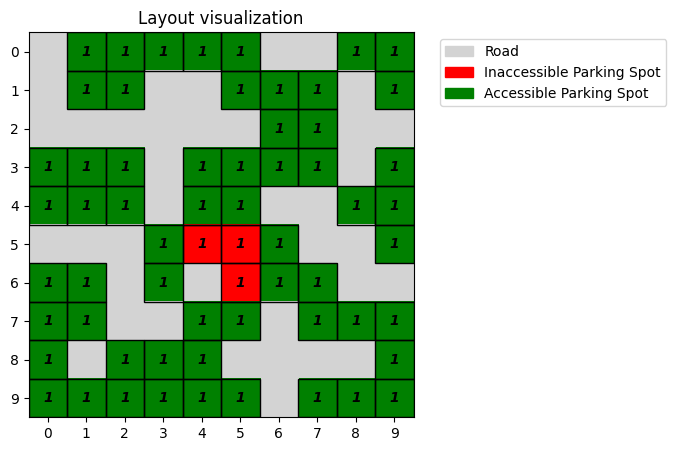

59


In [14]:
visualize_layout(x_best, highligt_pixels(x_best), save=True, name='best_parking_found.jpg')
print(evaluate(x_best))

In [11]:
# Generate the GIF
generate_gif(history, 'evolution.gif')

/tmp/ipykernel_235472/2936679169.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('temp.jpg'))
/tmp/ipykernel_235472/2936679169.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('temp.jpg'))
/tmp/ipykernel_235472/2936679169.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('temp.jpg'))
/tmp